# Project 2: The two-dimensional Ising model


The Ising model is described by the classical Hamiltonian

\begin{equation}
  \mathcal{H} = -J \sum_{\langle i,j \rangle} \sigma_i \sigma_j
\end{equation}

where $\sigma_i=\pm1$ is an Ising spin on the site $i$ of a square
lattice and $J>0$ is a ferromagnetic coupling between nearest-neighbor
spins. The square lattice has $N = L \times L$ sites.

Onsager solved this problem analytically and showed that on the
infinite lattice ($N \rightarrow \infty$) there is a
phase transition at a temperature $T_c$ from a disordered state at high temperatures
to a magnetic state with finite magnetization $m \ne 0$ where

\begin{equation}
  \langle m \rangle = \lim_{N \rightarrow \infty}
     \frac{1}{N} \sum_{i=1}^N \langle \sigma_i \rangle
\end{equation}

The value of the critical temperature (we set $k_B=1$) is

\begin{equation}
  \frac{T_c}{J} = \frac{2}{\log (1 + \sqrt{2})} \simeq 2.27
\end{equation}

The goal of this project is to study the two-dimensional Ising model
using a Monte Carlo algorithm and see whether we can find evidences
for the phase transition even though we will be dealing with finite
systems.


## Warmup: Compute $\pi$ by Monte Carlo

In order to get familiar with the generation of random numbers, you can try to write a
Monte Carlo algorithm to compute $\pi$. The idea, as we saw in the lecture, is to start
from a circle of radius 1, inside a square box of length 2. You then throw randomly
(uniformly) stones in the square box. After having thrown many stones you can compute
the ratio of those inside to those outside the circle. This will give you an estimate
for $\pi$.

*Challenge*: Show that the error bar on the value of $\pi$ goes like $1 / \sqrt{M}$, where
$M$ is the number of Monte Carlo steps. To do this, you will need to make several runs for
the same fixed $M$ and compute the statistical error bar.

## Solution

Here is a possible solution for the problem. In order to get an estimate for the error bar,
you can run e.g. 100 times a simulation for a given $M$ and compute the variance. Then you
can repeat this for different values of $M$.

<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_7757/3591668471.py:32: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Error bar on $\pi$", fontsize=22)


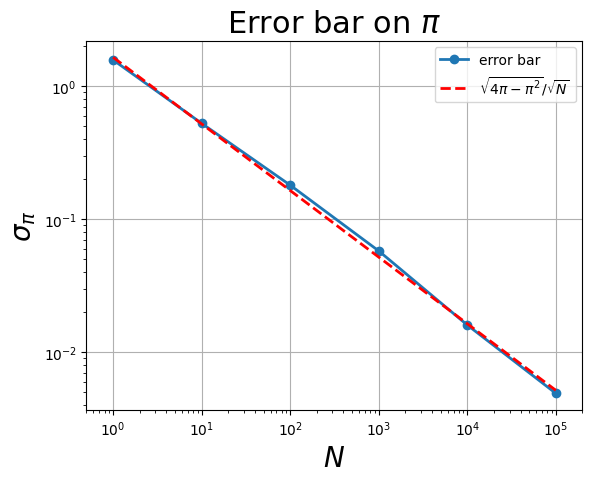

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt

n_orders = 6
n_pts, error_bar = np.zeros(n_orders), np.zeros(n_orders)

# loop over n_orders orders of magnitude
for p in range(n_orders):
    
    M = pow(10,p)    # number of points used to sample pi
    average_pi = 0.
    average_pi2 = 0.
    
    # compute pi estimate
    for i in range(100):
        stones = rnd.rand(M,2)
        dist = numpy.linalg.norm(stones, axis=1)
        inside = np.sum(dist < 1.)
        pi_estimate = 4.*inside/M
        average_pi += pi_estimate
        average_pi2 += pi_estimate**2
    average_pi /= 100
    average_pi2 /= 100

    n_pts[p] = M
    error_bar[p] = np.sqrt(average_pi2 - average_pi**2)

plt.loglog(n_pts, error_bar, '-o', lw=2, label='error bar')
plt.loglog(n_pts, np.sqrt(4*np.pi-np.pi**2)/np.sqrt(n_pts), 'r--', lw=2, label=r'$\sqrt{4\pi-\pi^2} / \sqrt{N}$')
plt.title("Error bar on $\pi$", fontsize=22)
plt.xlabel('$N$', fontsize=20)
plt.ylabel(r'$\sigma_\pi$', fontsize=20)
plt.grid()
plt.xlim(0.5, 2e5)
plt.legend()
plt.show()

## Part 1: Set up a class for the Ising model

Let's first start and write a class that will describe the Ising model. The class
should have a constructor taking $T$, $J$ and $L$ as parameters and generate
a random initial state. The state can be encoded in an $L\times L\,$
```numpy.array```. The class could have a structure like

```python
class Configuration:
    def __init__(self, L, ...):
        self.size = L
        self.spins = ...
        ...
    def get_energy(self):
        ...
        return e
    def get_magnetization(self):
        ...
        return m
```

In order to test your class, you can instantiate it and plot the spin configuration
after the initialization. You can use the function below to convert your
spin configuration (with +1 and -1) into an image array:

```python
def config_to_image(config):
    L = config.size
    im = np.zeros([L,L,3])
    for i,j in itertools.product(range(L), repeat=2):
        im[i,j,:] = (1.,0,0) if config.spins[i,j]==1 else (0.,0,0)
    return im
    
import matplotlib.pyplot as plt
plt.imshow(config_to_image(config))
```

You can also check your class methods by generating a configuration with all spins
up or down and see whether the energy and magnetization are those you expect.

## Solution

Here is the class for the configuration. It creates a random initial state and sets two member
variables: the energy and the magnetization. Two methods are used to do this.

In [2]:
import numpy as np
import numpy.random as rnd
import itertools

class Configuration:
    """A configuration of Ising spins"""

    def __init__(self, T, J, L):
        self.size = L
        self.J = J
        self.beta = 1./T
        self.spins = rnd.choice([-1,1], size=(L,L))      # either +1 or -1
        self.energy = self._get_energy()
        self.magnetization = self._get_magnetization()
        
    def _get_energy(self):
        """Returns the total energy"""
        energ = 0.
        for i,j in itertools.product(range(self.size), repeat=2):
            energ += -self.J * self.spins[i,j] * (self.spins[i,(j+1)%self.size] + self.spins[(i+1)%self.size,j])
        return energ
    
    def _get_magnetization(self):
        """Returns the total magnetization"""
        magnet = np.sum(self.spins)
        return magnet        
    
def config_to_image(config):
    """Turn an array into an image"""
    L = config.size
    im = np.zeros([L,L,3])
    for i,j in itertools.product(range(L), repeat=2):
        im[i,j,:] = (1,0,0) if config.spins[i,j]==1 else (0,0,0)
    return im

I just check the random spin state to see if it looks random

M = 30  E = -24.0


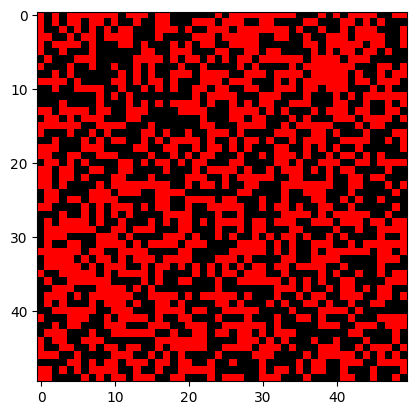

In [3]:
# Show the random configuration
config = Configuration(4.0, 1.0, 50)
plt.imshow(config_to_image(config), interpolation='none')
print("M =", config.magnetization, " E =", config.energy)

## Part 2: The Metropolis move

Here you will write a function that performs a Metropolis Monte Carlo
move on the configuration. The function takes an Ising configuration
(an instance of the `Configuration` class) as an argument and has
the following signature:

```python
def metropolis_move(config):
    ...
```

The function should chose a random site, compute the energy difference
between the old configuration and the new configuration where the spin
has been flipped and decide whether the move should be accepted or
not (using the Metropolis algorithm). Warning: in order to compute the
energy difference, only consider the energy change from the links involving
the flipped spin. Indeed, all the other links are unchanged and it would
be a waste of time to recompute the full energy every time.

How to check? Start from a small lattice, say $4 \times 4$, and call
`metropolis_move` many times at a rather high temperature. This way,
you should sample many different configuration. If you energy calculation
is right, the energy per spin should always be between -2 and 2.

## Solution

The implementation is quite straightforward. The only point where you should be careful, for performance
purposes, is to compute the energy difference just from the modification of the flipped spin that
only modifies the energy on 4 links.

In [4]:
def metropolis_move(config):
    """Modify (or not) a configuration with Metropolis algorithm"""
    
    L = config.size
    J = config.J
    beta = config.beta
    i, j = rnd.randint(L, size=(2)) # pick a random site
    
    # compute energy difference
    coef = 2 * J * config.spins[i,j]
    delta_energy = coef * (config.spins[i,(j+1)%L] + config.spins[(i+1)%L,j] + \
                           config.spins[i,(j-1)%L] + config.spins[(i-1)%L,j])
    
    # accept modification with Metropolis probability
    # if not accepted: leave configuration unchanged
    if rnd.random() < np.exp(-beta*delta_energy):
        config.spins[i,j] *= -1
        config.energy += delta_energy
        config.magnetization += 2*config.spins[i,j]

## Part 3: The Monte Carlo simulation live!

Write an animation that shows the evolution of the spins. In order for the animation not to be
too slow, the function that is repeatedly called by `FuncAnimation` should make many spin
flip trials (typically $L\times L$). Otherwise the animation will be really slow. You might want to get
more details about the function `matplotlib.animation.FuncAnimation` on the matplotlib
website.

See how the system behaves for different:

- Temperatures
- System sizes

## Solution

This is a possible solution to generate the animation.

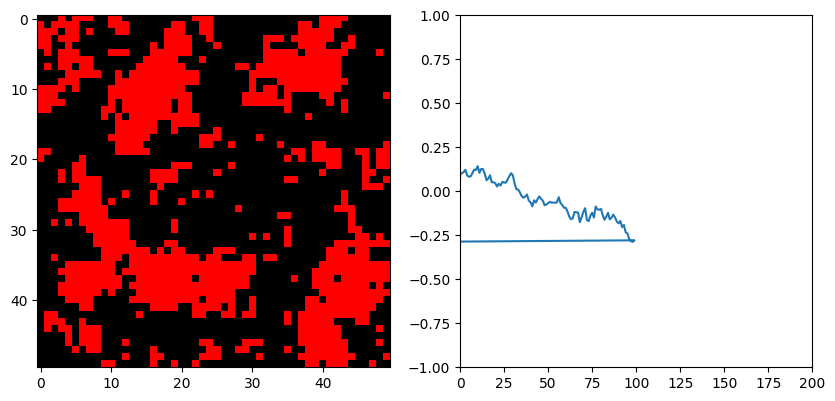

In [6]:
import matplotlib.animation as animation

L = 50
T = 2.4
length_cycle = L*L
nt = 200

# instantiate a configuration
config = Configuration(T, 1.0, L)

# a two-panel figure
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
im = ax1.imshow(config_to_image(config), interpolation='none')
ax2 = fig.add_subplot(122, aspect=100)
line, = ax2.plot([],[])
ax2.set_xlim(0,nt)
ax2.set_ylim(-1,1)

steps = []
magnet = []

def do_mc_cycle(n):
    
    for k in range(length_cycle):
        metropolis_move(config)
    
    m = config.magnetization/float(config.size**2)
    im.set_array(config_to_image(config))
    if len(steps) < nt: steps.append(n)
    if len(magnet) < nt:
        magnet.append(m)
    else:
        magnet.insert(nt, m)
        magnet.pop(0)

    line.set_data(steps, magnet)
    return (im, line)

ani = animation.FuncAnimation(fig, do_mc_cycle, frames=nt, interval=1, blit=False)
output_file = "ising.gif"
ani.save(output_file, writer="pillow", fps=15)

## Part 4: Compute physical averages

The animation above allows to get some insight into the physics of the
model. But it is necessary to compute some physical averages to understand
more. Because two configurations that only differ by a spin flip are very
correlated, one usually waits a certain number of steps before considering
a new configuration in the computation of an average. In practice, the
Monte Carlo simulation can be cut into cycles: a cycle is a certain number
of steps needed to decorrelate the configurations. Also, in the beginning of
the simulation, one needs to wait for the Markov chain to reach its stationary
distribution. These variables can be used:

- `length_cycle`: the number of steps between two *measurements*, i.e. between two
   configurations that are used to compute physical averages.

- `n_cyles`: the number of cycles used to compute the averages. This number
   corresponds to the number of measurements
   
- `n_warmup`: the number of cycles that are performed in the beginning of the
   simulation without any measurement. They are done so that the Markov
   chain reaches a stationary distribution.

You can now write a Monte Carlo simulation:

1. Compute the average magnetization $m$ as a function of the number of
  Monte Carlo steps on a $20 \times 20$ lattice. This will allow you to
  judge how many steps are necessary to reach equilibrium. How
  does this change with temperature and system size?

2. You can then more systematically compute the magnetization, the energy, the
  magnetic susceptibility and specific heat as a function of the temperature.
  Start with a rather small lattice $4 \times 4$ and then increase the size.
  How do these quantities vary?
  
You will see that these simulations can take some time. Rather than
plotting directly after the simulation is done, you might want to save
your averages into files and in another cell read the information from these
files to do the plots. It is very common to organize a numerical work like
this: a production part that generates the data and a postprocessing part
to do the plots etc. To save and read a numpy array you can use:

```python
  np.savetxt("my_file.dat", my_array)
  my_array = np.loadtxt("my_file.dat")
```

## Solution

In this first part I plot the magnetization as a function of Monte Carlo steps.

In [ ]:
L = 20
T = 2.0

n_cycles = 500
length_cycle = L**2

# instantiate a configuration (J=1)
config = Configuration(T, 1.0, L)

mr = np.zeros(n_cycles)

# Monte Carlo
for n in range(n_cycles):
    for k in range(length_cycle):
        metropolis_move(config)
    mr[n] = config.magnetization
mr /= float(L**2)
        
plt.plot(mr, '-')
plt.title("Magnetization", fontsize=25)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("$m$", fontsize=20)
plt.ylim(-1,1)

We now compute the averages and save the results in a file.

In [ ]:
# This is a production script, it will save the results in files
from tqdm.notebook import tqdm_notebook

# set temperature range
temp_range = np.hstack([np.arange(0.5,2.,0.5), np.arange(2.,2.5,0.05), np.arange(2.5,5,0.5)])
mag = np.zeros_like(temp_range)
energ = np.zeros_like(temp_range)
chi = np.zeros_like(temp_range)
cv = np.zeros_like(temp_range)

# lattice size
L = 4

pbar = tqdm_notebook(temp_range)
for i, T in enumerate(pbar):

    pbar.set_description(f"Processing T = {T:.2f}")

    config = Configuration(T, 1.0, L)
    
    av_m, av_m2, av_e, av_e2 = 0,0,0,0

    n_cycles = 10000
    length_cycle = L*L
    n_warmup = 1000

    # Monte Carlo
    for n in range(n_warmup+n_cycles):
        
        for k in range(length_cycle):
            metropolis_move(config)
        
        if n >= n_warmup:
            av_e  += config.energy
            av_e2 += config.energy**2
            av_m  += config.magnetization
            av_m2 += config.magnetization**2
            
    # normalize averages
    av_m  /= float(n_cycles)
    av_m2 /= float(n_cycles)
    av_e  /= float(n_cycles)
    av_e2 /= float(n_cycles)
            
    # get physical quantities
    fact = 1./L**2
    mag[i] = fact * av_m
    energ[i] = fact * av_e
    cv[i] = fact * (av_e2 - av_e**2) / T**2
    chi[i] = fact * (av_m2 - av_m**2) / T
    
    # print info because progress can be slow
    #print("T = %f and %.2f percent done"%(T, (100.*(i+1))/len(temp_range)))


# save quantities in a file
np.savetxt("energ_%i.dat"%L, energ)
np.savetxt("mag_%i.dat"%L, mag)
np.savetxt("cv_%i.dat"%L, cv)
np.savetxt("chi_%i.dat"%L, chi)

Here comes the analysis of the data

In [ ]:
L = 4
Tc = 2./(np.log(1+np.sqrt(2)))

energ = np.loadtxt("energ_%i.dat"%L)
mag = np.loadtxt("mag_%i.dat"%L)
cv = np.loadtxt("cv_%i.dat"%L)
chi = np.loadtxt("chi_%i.dat"%L)

plt.plot(temp_range, np.loadtxt("energ_%i.dat"%L)+2, '-o', label="energy")
plt.plot(temp_range, np.abs(np.loadtxt("mag_%i.dat"%L)), '-o', label="magnetization")
plt.plot(temp_range, np.loadtxt("cv_%i.dat"%L), '-o', label="specific heat")
plt.plot(temp_range, np.loadtxt("chi_%i.dat"%L)/10, '-o', label="susceptibility")

plt.plot([Tc,Tc], [0,1.6], '--', lw=3)
plt.legend()
plt.title("Physical quantities", fontsize=25)
plt.xlabel("$T$", fontsize=20)
plt.ylim(0,2)

## Part 5: Autocorrelation time

Above we said that configurations that differ only by a spin flip are very correlated
and that a certain number of moves are needed to make two configurations
independent. As a rule of thumb, we used $L\times L$ updates to disentangle
configurations.

However, as we will see here, as one gets closer to the phase transition, it becomes
harder and harder to decorrelate two configurations. A way to measure this in
the disordered state is to compute the *autocorrelation time* through the quantity

\begin{equation}
  \mathcal{C}(t) = \langle m(t) \, m(0) \rangle
\end{equation}

where $m(t)$ is the magnetization of the system at (Monte Carlo) time $t$.
If two configurations are completely decorrelated $\mathcal{C(t)}$ should
be zero. Usually $\mathcal{C}(t) \sim \exp(-t / \tau)$ where $\tau$ is the
autocorrelation time.

Write a code that computes the autocorrelation time at a given temperature
and study it as the temperature is reduced closer to the critical
temperature. You can start with an $8 \times 8$ lattice.

## Solution

Here we compute the average $\langle m(t) \, m(0) \rangle$.

In [ ]:
L = 8
T = 2.8
config = Configuration(T, 1.0, L)

nt = 100
av_m = 0.0
av_correl = np.zeros([nt])
previous_m = []

n_cycles = 5000
length_cycle = L**2
n_warmup = 100

# Monte Carlo
for n in range(n_cycles+n_warmup+nt):
    
    for k in range(length_cycle):
        metropolis_move(config)
            
    if n >= n_warmup:
        
        previous_m.insert(0, config.magnetization)
        
        # get rid of furthest previous m
        if n >= n_warmup+nt:
            previous_m.pop()
            av_m += config.magnetization
            for k in range(nt):
                av_correl[k] += previous_m[k] * config.magnetization
        
av_m  /= float(n_cycles)
av_correl /= float(n_cycles)

Now we plot it use a fit to find the autocorrelation time.

In [ ]:
from scipy.optimize import curve_fit

n_fit_pts = 40
xr = np.arange(n_fit_pts, dtype=float)

# fit autocorrelation function
f = lambda x, a, b: a*np.exp(-x/float(b))
a, b = curve_fit(f, xr, (av_correl-av_m**2)[0:n_fit_pts], p0=(1000,1))[0]
print("Autocorrelation time =", b)

plt.plot(np.log(np.abs(av_correl-av_m**2)), '-ro', lw=2, alpha=0.5)

plt.plot(xr, np.log(f(xr, a, b)), 'b-', lw=2)
plt.plot([0,100], [0,0], 'k--', lw=2)

plt.title("Autocorrelation function", fontsize=25)
plt.xlabel("$t$", fontsize=20)
plt.ylabel(r"$\mathcal{C}(t)$", fontsize=20)
#plt.xlim(0, n_fit_pts+10)